# Using CellTypist for cell type classification
This notebook showcases the cell type classification for scRNA-seq query data by retrieving the most likely cell type labels from the built-in CellTypist models.

## Install CellTypist

In [1]:
import sys
import subprocess
import warnings

# Suppress specific warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
warnings.filterwarnings("ignore", category=NumbaDeprecationWarning)
warnings.filterwarnings("ignore", category=NumbaPendingDeprecationWarning)

# List of required packages
required_packages = [
    "anndata",
    "scanpy",
    "besca",
    "matplotlib",
    "pandas",
    "celltypist"
]

# Install packages quietly
for package in required_packages:
    subprocess.run(
        [sys.executable, "-m", "pip", "install", package, "--quiet"],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL
    )

In [2]:
%%capture --no-display
import anndata
import scanpy as sc
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import besca
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
import operator
import celltypist
from celltypist import models

## Load a scRNA-seq dataset .h5ad file

In [4]:
##  REPLACE <SAMPLE MATRIX FILE> with the filename of your matrix
adata = sc.read_h5ad('datasets/PA04_Tumor.h5ad')


## Assign cell type labels using a CellTypist built-in model
In this section, we show the procedure of transferring cell type labels from a custom model to the query dataset.

In [6]:
## REPLACE <YOUR MODEL FILENAME> with the PKL file you made
custom_model = models.Model.load(model = 'UCSC_human_pancreas_model.pkl')

Show the built-in model meta information:

In [7]:
custom_model

CellTypist model with 21 cell types and 51863 features
    date: 2025-08-10 11:08:01.514089
    cell types: B cell, Mast cell, ..., t cell
    features: WASH7P, MIR6859-1, ..., MT-TP

#### This model contains 15 cell states.

In [8]:
custom_model.cell_types

array(['B cell', 'Mast cell', 'NK cell', 'T cell', 'b cell',
       'endothelial cell', 'fibroblast', 'mast cell', 'myeloid cell',
       'pancreatic acinar cell', 'pancreatic acing cell',
       'pancreatic alpha cell', 'pancreatic beta cell',
       'pancreatic delta cell', 'pancreatic ductal cell',
       'pancreatic pp cell', 'pancreatic stellate cell',
       'pancreatic stellate cell activated',
       'pancreatic stellate cell quiescent', 'plasma cell', 't cell'],
      dtype='<U34')

### Transfer cell type labels from this model to the query dataset using [celltypist.annotate](https://celltypist.readthedocs.io/en/latest/celltypist.annotate.html).

In [9]:
predictions = celltypist.annotate(adata, custom_model, majority_voting = True)

By default (`majority_voting = False`), CellTypist will infer the identity of each query cell independently. This leads to raw predicted cell type labels, and usually finishes within seconds or minutes depending on the size of the query data. You can also turn on the majority-voting classifier (`majority_voting = True`), which refines cell identities within local subclusters after an over-clustering approach at the cost of increased runtime.

The results include both predicted cell type labels (`predicted_labels`), over-clustering result (`over_clustering`), and predicted labels after majority voting in local subclusters (`majority_voting`). Note in the `predicted_labels`, each query cell gets its inferred label by choosing the most probable cell type among all possible cell types in the given model.

In [10]:
predictions.predicted_labels

,predicted_labels,over_clustering,majority_voting
PDAC04-Tumor-GEX_out_AAACCTGAGCCATCGC-1,myeloid cell,0,myeloid cell
PDAC04-Tumor-GEX_out_AAACCTGAGGACACCA-1,myeloid cell,1,myeloid cell
PDAC04-Tumor-GEX_out_AAACCTGAGTCGCCGT-1,myeloid cell,2,myeloid cell
PDAC04-Tumor-GEX_out_AAACCTGAGTTGTCGT-1,myeloid cell,3,myeloid cell
PDAC04-Tumor-GEX_out_AAACCTGCAAAGCAAT-1,myeloid cell,5,myeloid cell
...,...,...,...
PDAC04-Tumor-GEX_out_TTTGTCATCGCGATCG-1,myeloid cell,33,myeloid cell
PDAC04-Tumor-GEX_out_TTTGTCATCGGATGTT-1,myeloid cell,55,myeloid cell
PDAC04-Tumor-GEX_out_TTTGTCATCGTAGGAG-1,T cell,57,myeloid cell
PDAC04-Tumor-GEX_out_TTTGTCATCGTTGCCT-1,myeloid cell,14,myeloid cell


### Transform the prediction result into an `AnnData`.

In [11]:
# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
adata = predictions.to_adata()

Compared to `adata`, the new `adata` has additional prediction information in `adata.obs` (`predicted_labels`, `over_clustering`, `majority_voting` and `conf_score`). Of note, all these columns can be prefixed with a specific string by setting `prefix` in [to_adata](https://celltypist.readthedocs.io/en/latest/celltypist.classifier.AnnotationResult.html#celltypist.classifier.AnnotationResult.to_adata).

In [12]:
adata.obs

,patient,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,...,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,doublet_score,predicted_doublet,predicted_labels,over_clustering,majority_voting,conf_score
PDAC04-Tumor-GEX_out_AAACCTGAGCCATCGC-1,PA04_Tumor,1113,1113,7.015712,2851.0,7.955776,47.421957,55.559453,64.293230,78.498772,...,0.0,0.0,0.0,0.0,0.037564,False,myeloid cell,0,myeloid cell,7.130396e-216
PDAC04-Tumor-GEX_out_AAACCTGAGGACACCA-1,PA04_Tumor,1060,1060,6.966967,1870.0,7.534228,37.700535,43.582888,54.010695,70.053476,...,0.0,0.0,0.0,0.0,0.115723,False,myeloid cell,1,myeloid cell,0.000000e+00
PDAC04-Tumor-GEX_out_AAACCTGAGTCGCCGT-1,PA04_Tumor,853,853,6.749931,1740.0,7.462215,45.402299,52.643678,62.471264,79.712644,...,0.0,0.0,0.0,0.0,0.020171,False,myeloid cell,2,myeloid cell,6.202948e-232
PDAC04-Tumor-GEX_out_AAACCTGAGTTGTCGT-1,PA04_Tumor,834,834,6.727432,2076.0,7.638680,50.192678,59.248555,69.364162,83.911368,...,0.0,0.0,0.0,0.0,0.011081,False,myeloid cell,3,myeloid cell,4.365406e-198
PDAC04-Tumor-GEX_out_AAACCTGCAAAGCAAT-1,PA04_Tumor,656,656,6.487684,1248.0,7.130098,40.945513,51.442308,63.461538,87.500000,...,0.0,0.0,0.0,0.0,0.022857,False,myeloid cell,5,myeloid cell,1.420888e-205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PDAC04-Tumor-GEX_out_TTTGTCATCGCGATCG-1,PA04_Tumor,1893,1893,7.546446,5375.0,8.589700,42.586047,50.400000,58.883721,72.074419,...,0.0,0.0,0.0,0.0,0.068864,False,myeloid cell,33,myeloid cell,3.875555e-228
PDAC04-Tumor-GEX_out_TTTGTCATCGGATGTT-1,PA04_Tumor,586,586,6.375025,1831.0,7.513164,62.370289,69.907155,78.918624,95.303113,...,0.0,0.0,0.0,0.0,0.159016,False,myeloid cell,55,myeloid cell,3.354875e-126
PDAC04-Tumor-GEX_out_TTTGTCATCGTAGGAG-1,PA04_Tumor,1559,1559,7.352441,3269.0,8.092546,31.477516,40.134598,49.984705,67.604772,...,0.0,0.0,0.0,0.0,0.048732,False,T cell,57,myeloid cell,1.474642e-198
PDAC04-Tumor-GEX_out_TTTGTCATCGTTGCCT-1,PA04_Tumor,1360,1360,7.215975,2372.0,7.771910,28.962901,36.635750,46.247892,63.743676,...,0.0,0.0,0.0,0.0,0.007636,False,myeloid cell,14,myeloid cell,1.830895e-233


In addition to this meta information added, the neighborhood graph constructed during over-clustering is also stored in the `adata`
(If a pre-calculated neighborhood graph is already present in the `AnnData`, this graph construction step will be skipped).  
This graph can be used to derive the cell embeddings, such as the UMAP coordinates.

In [13]:
sc.tl.umap(adata)

### Visualise the prediction results.

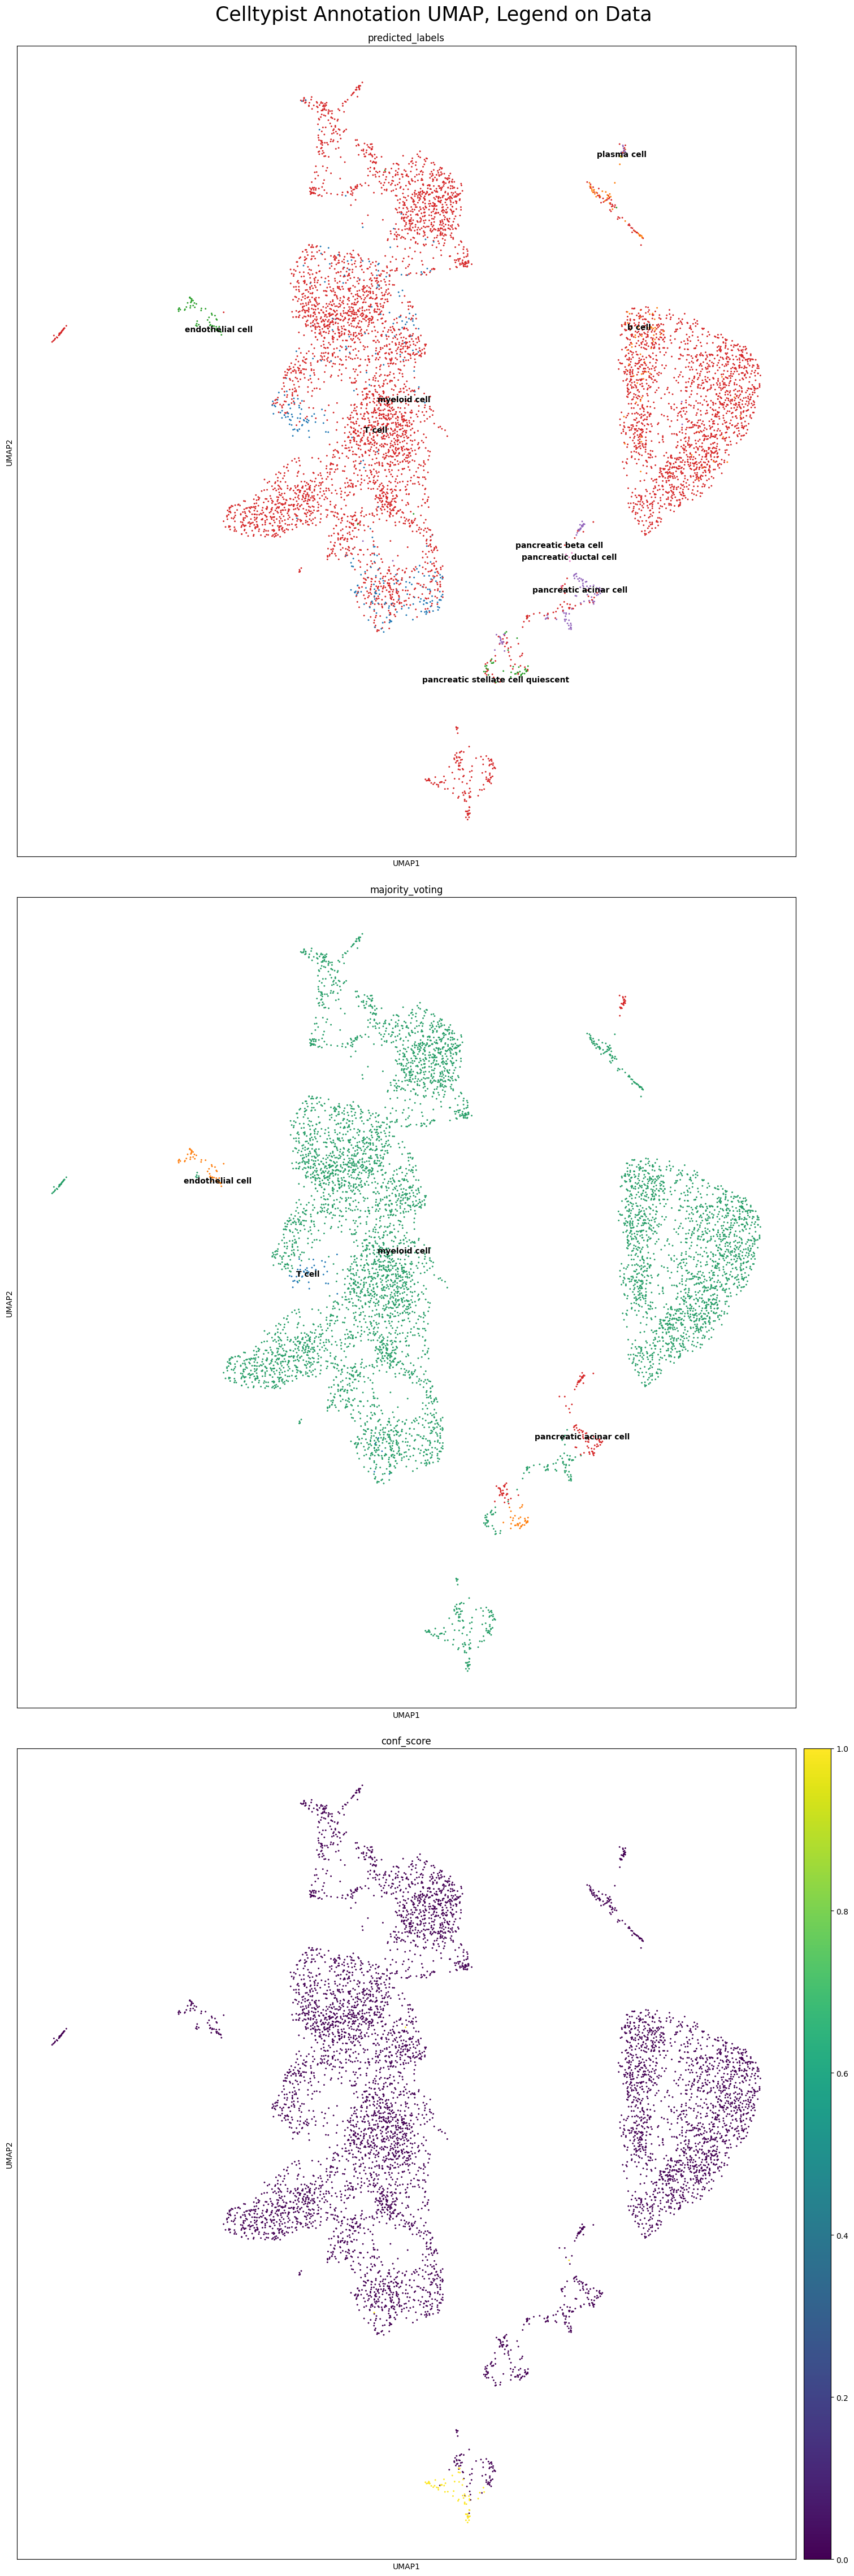

In [14]:
fig, ax = plt.subplots(3,1,figsize = (15,45), constrained_layout=True)

fig.suptitle("Celltypist Annotation UMAP, Legend on Data", x=0.25, y=1.01, horizontalalignment='left', fontsize=25)

ax[0].set_title('Predicted Labels'),
predicted_label_UMAP=sc.pl.umap(adata, color = ['predicted_labels'], legend_loc = 'on data',ax=ax[0], show=False) 

ax[1].set_title('Majority Voting'),
majority_vote_UMAP=sc.pl.umap(adata, color = ['majority_voting'], palette=sc.pl.palettes.default_20, legend_loc = 'on data', ax=ax[1], show=False)
    
ax[2].set_title('Confidence Score'),
conf_score_UMAP=sc.pl.umap(adata, color = ['conf_score'], legend_loc = 'on data', ax=ax[2])
  

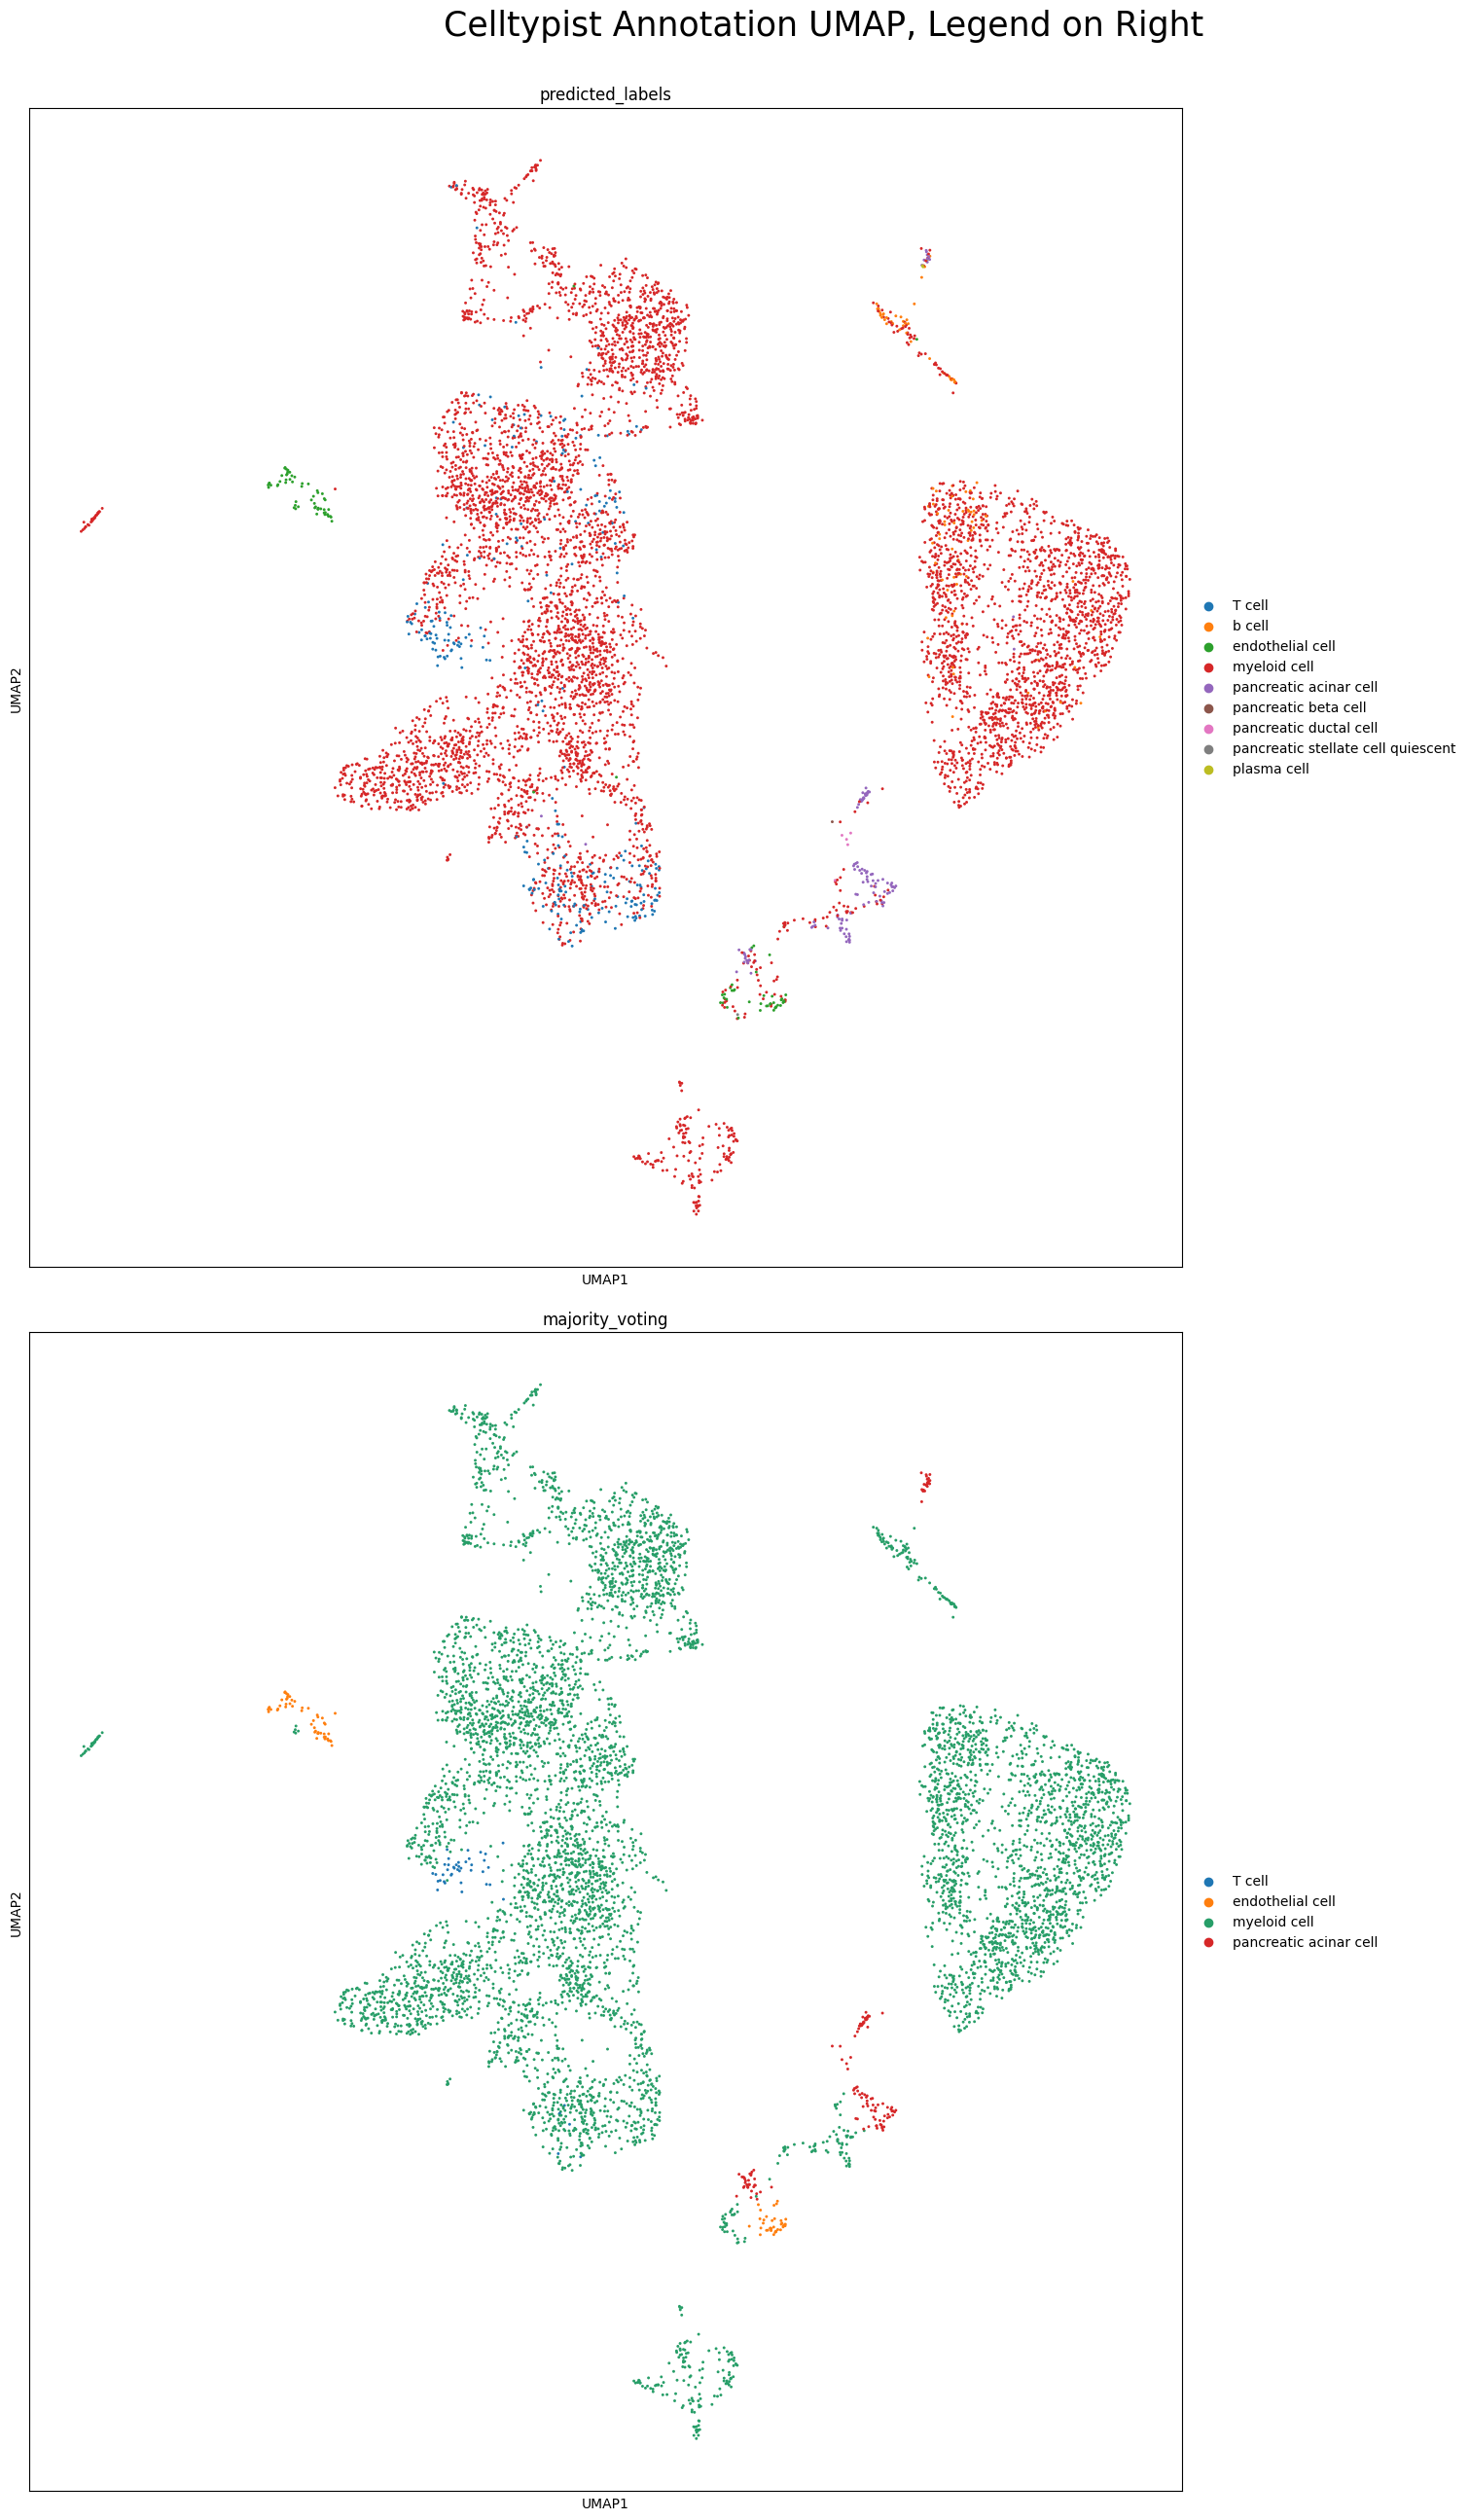

In [15]:
fig, ax = plt.subplots(2,1,figsize = (15,25), constrained_layout=True)

fig.suptitle("Celltypist Annotation UMAP, Legend on Right", x=0.3, y=1.03, horizontalalignment='left', fontsize=25)

ax[0].set_title('Predicted Labels'),
predicted_label_UMAP=sc.pl.umap(adata, color = ['predicted_labels'], legend_loc = 'right margin',ax=ax[0], show=False) 

ax[1].set_title('Majority Voting'),
majority_vote_UMAP=sc.pl.umap(adata, color = ['majority_voting'], palette=sc.pl.palettes.default_20, legend_loc = 'right margin', ax=ax[1], show=False)

### Total occurrence of cell population in all samples (majority voting)

In [16]:
count_types = besca.tl.count_occurrence(adata, count_variable='majority_voting', add_percentage=False)
print(count_types)

                        Counts
myeloid cell              6512
pancreatic acinar cell     141
endothelial cell            90
T cell                      44


### Total occurrence of cell population per sample (majority voting)

In [18]:
# unique_sample_names = adata.obs['sample'].unique().tolist()

# for sample in unique_sample_names:
#     # Filter the AnnData object to include only rows with the current sample
#     subset_adata_built_in = adata[adata.obs['sample'] == sample, :]

#     # Count occurrences for the current sample
#     count_types = besca.tl.count_occurrence(subset_adata_built_in, count_variable='majority_voting', add_percentage=False)
#     print(sample)
#     print('-----------')
#     print(count_types)
#     print('-----------')

## Examine Hi/Low Neural Invansion Genes of Interest

#### Here you can plug in the genes of interest associated with neural invasion in your patients and light up the cells expressing those genes

In [19]:
# REPLACE PLACEHOLDER GENE NAMES HERE WITH GENE SYMBOLS
examine_genes = ['CCL21','VCAM1','CCR7']
subset_ad = adata[:, examine_genes]

subset_ad.var

,gene_ids,feature_types,n_cells,mt,ribo,hb,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
CCL21,CCL21,Gene Expression,62,False,False,False,62,0.056893,0.055334,99.716221,1243.0,7.126087
VCAM1,VCAM1,Gene Expression,356,False,False,False,356,0.045542,0.044535,98.370560,995.0,6.903747
CCR7,CCR7,Gene Expression,4947,False,False,False,4947,0.573142,0.453075,77.357195,12522.0,9.435322


In [20]:
subset_df = pd.DataFrame(subset_ad.X.toarray(), index=subset_ad.obs_names, columns=examine_genes)
subset_df

,CCL21,VCAM1,CCR7
PDAC04-Tumor-GEX_out_AAACCTGAGCCATCGC-1,0.0,0.000000,0.000000
PDAC04-Tumor-GEX_out_AAACCTGAGGACACCA-1,0.0,1.119952,0.000000
PDAC04-Tumor-GEX_out_AAACCTGAGTCGCCGT-1,0.0,0.000000,1.693399
PDAC04-Tumor-GEX_out_AAACCTGAGTTGTCGT-1,0.0,0.000000,0.000000
PDAC04-Tumor-GEX_out_AAACCTGCAAAGCAAT-1,0.0,0.000000,0.000000
...,...,...,...
PDAC04-Tumor-GEX_out_TTTGTCATCGCGATCG-1,0.0,0.000000,0.000000
PDAC04-Tumor-GEX_out_TTTGTCATCGGATGTT-1,0.0,0.000000,0.000000
PDAC04-Tumor-GEX_out_TTTGTCATCGTAGGAG-1,0.0,0.000000,0.000000
PDAC04-Tumor-GEX_out_TTTGTCATCGTTGCCT-1,0.0,0.000000,0.000000


In [21]:
## Create columns for the genes of interest

## Add cell type annotation
ad_df_w_annot = sc.get.obs_df(subset_ad, examine_genes + ['predicted_labels','majority_voting'], use_raw=False)
## Display the table with annotation
ad_df_w_annot

,CCL21,VCAM1,CCR7,predicted_labels,majority_voting
PDAC04-Tumor-GEX_out_AAACCTGAGCCATCGC-1,0.0,0.000000,0.000000,myeloid cell,myeloid cell
PDAC04-Tumor-GEX_out_AAACCTGAGGACACCA-1,0.0,1.119952,0.000000,myeloid cell,myeloid cell
PDAC04-Tumor-GEX_out_AAACCTGAGTCGCCGT-1,0.0,0.000000,1.693399,myeloid cell,myeloid cell
PDAC04-Tumor-GEX_out_AAACCTGAGTTGTCGT-1,0.0,0.000000,0.000000,myeloid cell,myeloid cell
PDAC04-Tumor-GEX_out_AAACCTGCAAAGCAAT-1,0.0,0.000000,0.000000,myeloid cell,myeloid cell
...,...,...,...,...,...
PDAC04-Tumor-GEX_out_TTTGTCATCGCGATCG-1,0.0,0.000000,0.000000,myeloid cell,myeloid cell
PDAC04-Tumor-GEX_out_TTTGTCATCGGATGTT-1,0.0,0.000000,0.000000,myeloid cell,myeloid cell
PDAC04-Tumor-GEX_out_TTTGTCATCGTAGGAG-1,0.0,0.000000,0.000000,T cell,myeloid cell
PDAC04-Tumor-GEX_out_TTTGTCATCGTTGCCT-1,0.0,0.000000,0.000000,myeloid cell,myeloid cell


In [22]:
# Step 1: Create a dictionary of boolean Series (True if gene expression > 0)
nonzero_dict = {gene: (ad_df_w_annot[gene] > 0) for gene in examine_genes}

# Step 2: Combine all Series using logical AND to get cells expressing all genes
all_nonzero = reduce(operator.or_, nonzero_dict.values())

# Step 3: Convert the combined boolean Series to a DataFrame
df_genes_bool = all_nonzero.to_frame(name='NI_Genes')

# Step 4: Convert each gene's boolean Series into a DataFrame with '_bool' suffix
gene_bool_dfs = {
    f"df_{gene}_bool": series.to_frame(name=f"{gene}_bool")
    for gene, series in nonzero_dict.items()
}


# Step 5: Subset the original dataframe to get rows where all genes are expressed
ad_ni = ad_df_w_annot.loc[all_nonzero, :]


In [23]:
## List cell barcodes that pass the TRUE check where all Neural-Invasion (ni)-associated genes are expressed
ad_ni

,CCL21,VCAM1,CCR7,predicted_labels,majority_voting
PDAC04-Tumor-GEX_out_AAACCTGAGGACACCA-1,0.0,1.119952,0.000000,myeloid cell,myeloid cell
PDAC04-Tumor-GEX_out_AAACCTGAGTCGCCGT-1,0.0,0.000000,1.693399,myeloid cell,myeloid cell
PDAC04-Tumor-GEX_out_AAACCTGCAATCCAAC-1,0.0,0.000000,1.170647,myeloid cell,myeloid cell
PDAC04-Tumor-GEX_out_AAACCTGCAGACACTT-1,0.0,0.000000,1.132350,myeloid cell,myeloid cell
PDAC04-Tumor-GEX_out_AAACCTGTCAGCTTAG-1,0.0,0.000000,1.772805,myeloid cell,myeloid cell
...,...,...,...,...,...
PDAC04-Tumor-GEX_out_TTTGCGCTCCACGCAG-1,0.0,0.000000,0.853212,myeloid cell,myeloid cell
PDAC04-Tumor-GEX_out_TTTGCGCTCTGAGGGA-1,0.0,0.000000,1.087513,myeloid cell,myeloid cell
PDAC04-Tumor-GEX_out_TTTGGTTAGTCGTTTG-1,0.0,0.000000,1.103994,myeloid cell,myeloid cell
PDAC04-Tumor-GEX_out_TTTGGTTTCAGTCAGT-1,0.0,0.000000,1.943472,myeloid cell,myeloid cell


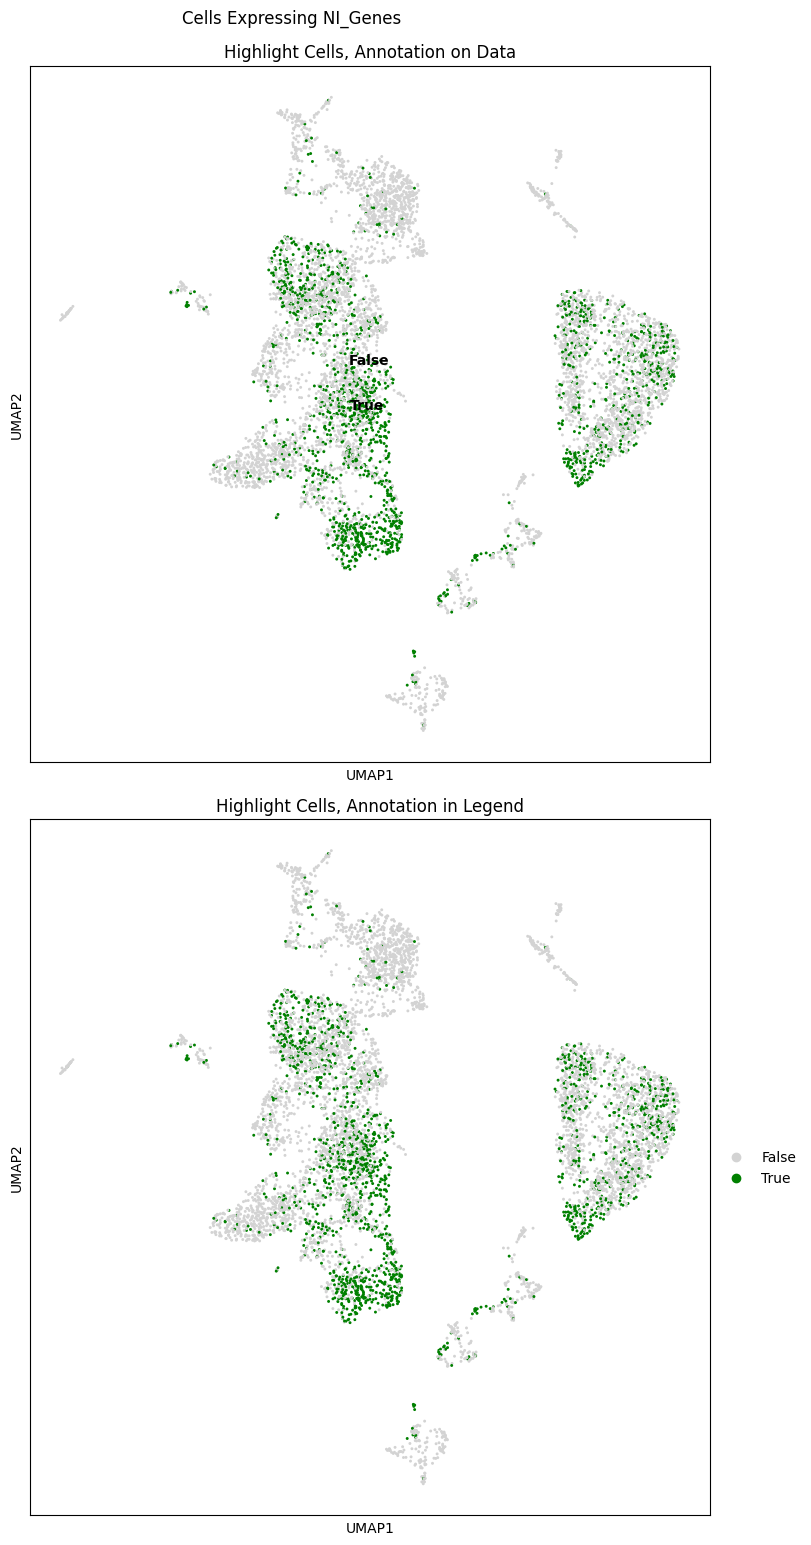

In [24]:
# Subset table "NettaGenes" containing cells expressing all genes of interest
adata.obs['NI_Genes'] = all_nonzero
adata.obs['NI_Genes'] = adata.obs['NI_Genes'].astype(str).astype('category')

# Create subplots with specific size
fig, ax = plt.subplots(2, 1, figsize=(8, 15), constrained_layout=True)

# Set the title of the entire figure
fig.suptitle("Cells Expressing NI_Genes", x=0.22, y=1.02, horizontalalignment='left', fontsize=12)

# Plot UMAP on the first axis (highlight cells with legend on the right)
ax[0].set_title('Highlight Cells, Legend on Right')
on_right_UMAP = sc.pl.umap(
    adata, 
    color='NI_Genes', 
    legend_loc='on data', 
    title='Highlight Cells, Annotation on Data', 
    frameon=True, 
    palette={"False": "#D3D3D3", "True": "green"}, 
    ax=ax[0], 
    show=False
)

# Plot UMAP on the second axis (highlight cells with legend on the margin)
ax[1].set_title('Highlight Cells on Data')
on_data_UMAP = sc.pl.umap(
    adata, 
    color='NI_Genes', 
    legend_loc='right margin', 
    title='Highlight Cells, Annotation in Legend', 
    frameon=True, 
    ax=ax[1], 
    show=False
)


## Celltypist Predicted Labels to Majority Voting Dotplot

Actually, you may not need to explicitly convert `predictions` output by `celltypist.annotate` into an `AnnData` as above. A more useful way is to use the visualisation function [celltypist.dotplot](https://celltypist.readthedocs.io/en/latest/celltypist.dotplot.html), which quantitatively compares the CellTypist prediction result (e.g. `majority_voting` here) with the cell types pre-defined in the `AnnData` (here `cell_type`). You can also change the value of `use_as_prediction` to `predicted_labels` to compare the raw prediction result with the pre-defined cell types.

For each pre-defined cell type (each column from the dot plot), this plot shows how it can be 'decomposed' into different cell types predicted by CellTypist (rows).

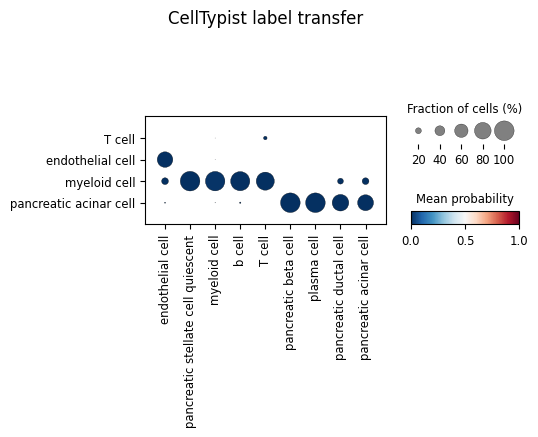

In [25]:
celltypist.dotplot(predictions, use_as_reference = 'predicted_labels', use_as_prediction = 'majority_voting')

## Examine expression of cell type-driving genes

Each model can be examined in terms of the driving genes for each cell type. Pick a cell type from the model:

In [26]:
custom_model.cell_types

array(['B cell', 'Mast cell', 'NK cell', 'T cell', 'b cell',
       'endothelial cell', 'fibroblast', 'mast cell', 'myeloid cell',
       'pancreatic acinar cell', 'pancreatic acing cell',
       'pancreatic alpha cell', 'pancreatic beta cell',
       'pancreatic delta cell', 'pancreatic ductal cell',
       'pancreatic pp cell', 'pancreatic stellate cell',
       'pancreatic stellate cell activated',
       'pancreatic stellate cell quiescent', 'plasma cell', 't cell'],
      dtype='<U34')

Extract the top 10 driving genes of `<CELLTYPE OF INTEREST>` using the [extract_top_markers](https://celltypist.readthedocs.io/en/latest/celltypist.models.Model.html#celltypist.models.Model.extract_top_markers) method.

In [27]:
## REPLACE 'CELLTYPE OF INTEREST' with a Cell Type above 
top_20_genes = custom_model.extract_top_markers("T cell", 20)
top_20_genes

array(['CD3G', 'IL7R', 'CD3E', 'CD3D', 'TRAC', 'CD2', 'CD8A', 'GZMA',
       'IKZF3', 'CD8B', 'BCL11B', 'CCL5', 'CD96', 'TRBC2', 'KLRC1',
       'IKZF1', 'LINC01871', 'CXCR6', 'RHOH', 'CXCR3'], dtype=object)

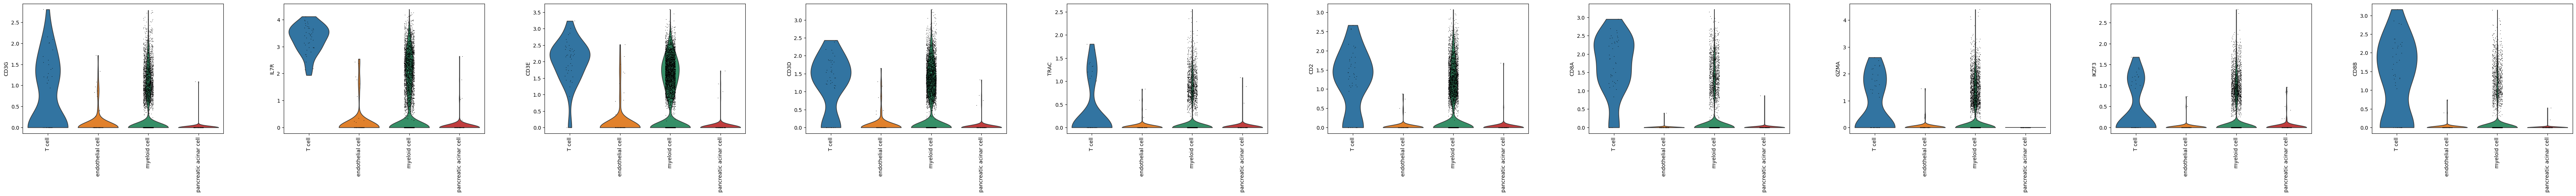

In [28]:
# Check expression of the twelve genes in the query set.
# Here we use `majority_voting` from CellTypist as the cell type labels for this dataset.
genes_present = [gene for gene in top_20_genes if gene in adata.var_names]

# Select the top 10 from those present
top_10_genes_present = genes_present[:10]

# Create violin plot of expression by majority voting labels
sc.pl.violin(adata, top_10_genes_present, groupby='majority_voting', rotation=90)